In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Load data
url = 'https://raw.githubusercontent.com/C4AnN/Models/data/dataset_processing%20(Model%20LR%202)/file_gabungan2.csv'
store_sales = pd.read_csv(url)
store_sales['date'] = pd.to_datetime(store_sales['date'])

# Categorize data based on price
def categorize_price(price):
    if price <= 8000000:
        return 'low'
    elif 8000000 < price <= 16000000:
        return 'mid'
    else:
        return 'high'

store_sales['category'] = store_sales['price'].apply(categorize_price)

# Drop unnecessary columns
store_sales = store_sales.drop(['name', 'price'], axis=1)

# Function to process and predict for each category
def process_category(data, category_name, window_size):
    data = data[data['category'] == category_name].drop(['category'], axis=1)
    data['date'] = data['date'].dt.to_period("M")
    monthly_sales = data.groupby('date').sum().reset_index()
    monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

    # Calculate sales difference
    monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
    monthly_sales = monthly_sales.dropna()

    # Prepare supervised data with a window size
    supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)
    for i in range(1, window_size + 1):
        col_name = 'month_' + str(i)
        supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
    supervised_data = supervised_data.dropna().reset_index(drop=True)

    # Split into train and test data
    train_data = supervised_data[:-24]
    test_data = supervised_data[-12:]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train_data)
    train_data_scaled = scaler.transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    X_train, y_train = train_data_scaled[:, 1:], train_data_scaled[:, 0]
    X_test, y_test = test_data_scaled[:, 1:], test_data_scaled[:, 0]

    # Reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(200, activation='tanh', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Setup callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

    # Save the model
    model.save(f'model/best_model_{category_name}.keras')

    # Make predictions
    lstm_pre = model.predict(X_test)

    # Prepare prediction DataFrame
    sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
    predict_df = pd.DataFrame(sales_dates, columns=['date'])

    act_sales = monthly_sales['sales'][-13:].to_list()
    lstm_pre = lstm_pre.reshape(-1, 1)
    lstm_pre_test_set = np.concatenate([lstm_pre, X_test.reshape((X_test.shape[0], X_test.shape[1]))], axis=1)
    lstm_pre_test_set = scaler.inverse_transform(lstm_pre_test_set)

    result_list = []
    for index in range(0, len(lstm_pre_test_set)):
        result_list.append(lstm_pre_test_set[index][0] + act_sales[index + 1])
    lstm_pre_series = pd.Series(result_list, name="LSTM Prediction")
    predict_df = predict_df.merge(lstm_pre_series, left_index=True, right_index=True)

    # Predict next 12 months
    future_predictions = []
    last_data = supervised_data[-1:].copy()

    for _ in range(12):
        last_data_scaled = scaler.transform(last_data)
        X_last = last_data_scaled[:, 1:].reshape((1, X_train.shape[1], 1))
        next_pred = model.predict(X_last)[0, 0]

        future_pred = np.concatenate([[next_pred], last_data_scaled[0, 1:]])
        future_pred = scaler.inverse_transform([future_pred])

        future_predictions.append(future_pred[0][0] + monthly_sales['sales'].iloc[-1])

        new_row = np.append([next_pred], last_data.values[0, :-1])
        last_data = pd.DataFrame([new_row], columns=supervised_data.columns)

    future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')
    future_df = pd.DataFrame({'date': future_dates, 'LSTM Prediction': future_predictions})

    return monthly_sales, predict_df, future_df, model

# Process and predict for each category using window size of 12 months
window_size = 6  # Increase window size to consider more historical data

low_sales, low_predict_df, low_future_df, low_model = process_category(store_sales, 'low', window_size)
mid_sales, mid_predict_df, mid_future_df, mid_model = process_category(store_sales, 'mid', window_size)
high_sales, high_predict_df, high_future_df, high_model = process_category(store_sales, 'high', window_size)

# Save all models into a single .h5 file
all_models = [low_model, mid_model, high_model]
model_file_path = 'model/all_models.h5'
for model in all_models:
    if os.path.exists(model_file_path):
        os.remove(model_file_path)
    model.save(model_file_path)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 445ms/step - loss: 0.3058 - val_loss: 0.5109
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2757 - val_loss: 0.5098
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2659 - val_loss: 0.5121
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2435 - val_loss: 0.5256
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2429 - val_loss: 0.5551
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2693 - val_loss: 0.6025
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2334 - val_loss: 0.6386
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2290 - val_loss: 0.6627
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.2414 - val_loss: 0.6485
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2507 - val_loss: 0.6363
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2295 - val_loss: 0.6240
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2137 - val_l

C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\3910501917.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 463ms/step - loss: 0.1880 - val_loss: 0.1279
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2043 - val_loss: 0.1159
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2071 - val_loss: 0.1077
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.1780 - val_loss: 0.1029
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1562 - val_loss: 0.0980
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1770 - val_loss: 0.0943
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1601 - val_loss: 0.0905
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.1453 - val_loss: 0.0878
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1566 - val_loss: 0.0855
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1303 - val_loss: 0.0855
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1361 - val_loss: 0.0847
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1672 - val_loss: 0.0842

C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\3910501917.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step - loss: 0.2361 - val_loss: 0.5058
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2330 - val_loss: 0.5016
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2449 - val_loss: 0.4964
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2191 - val_loss: 0.4942
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2001 - val_loss: 0.4934
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.2299 - val_loss: 0.4961
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2415 - val_loss: 0.4970
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2310 - val_loss: 0.4976
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2089 - val_loss: 0.5012
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2368 - val_loss: 0.5045
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.2299 - val_loss: 0.5090
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2085 - val_loss: 0.5148

C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\3910501917.py:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


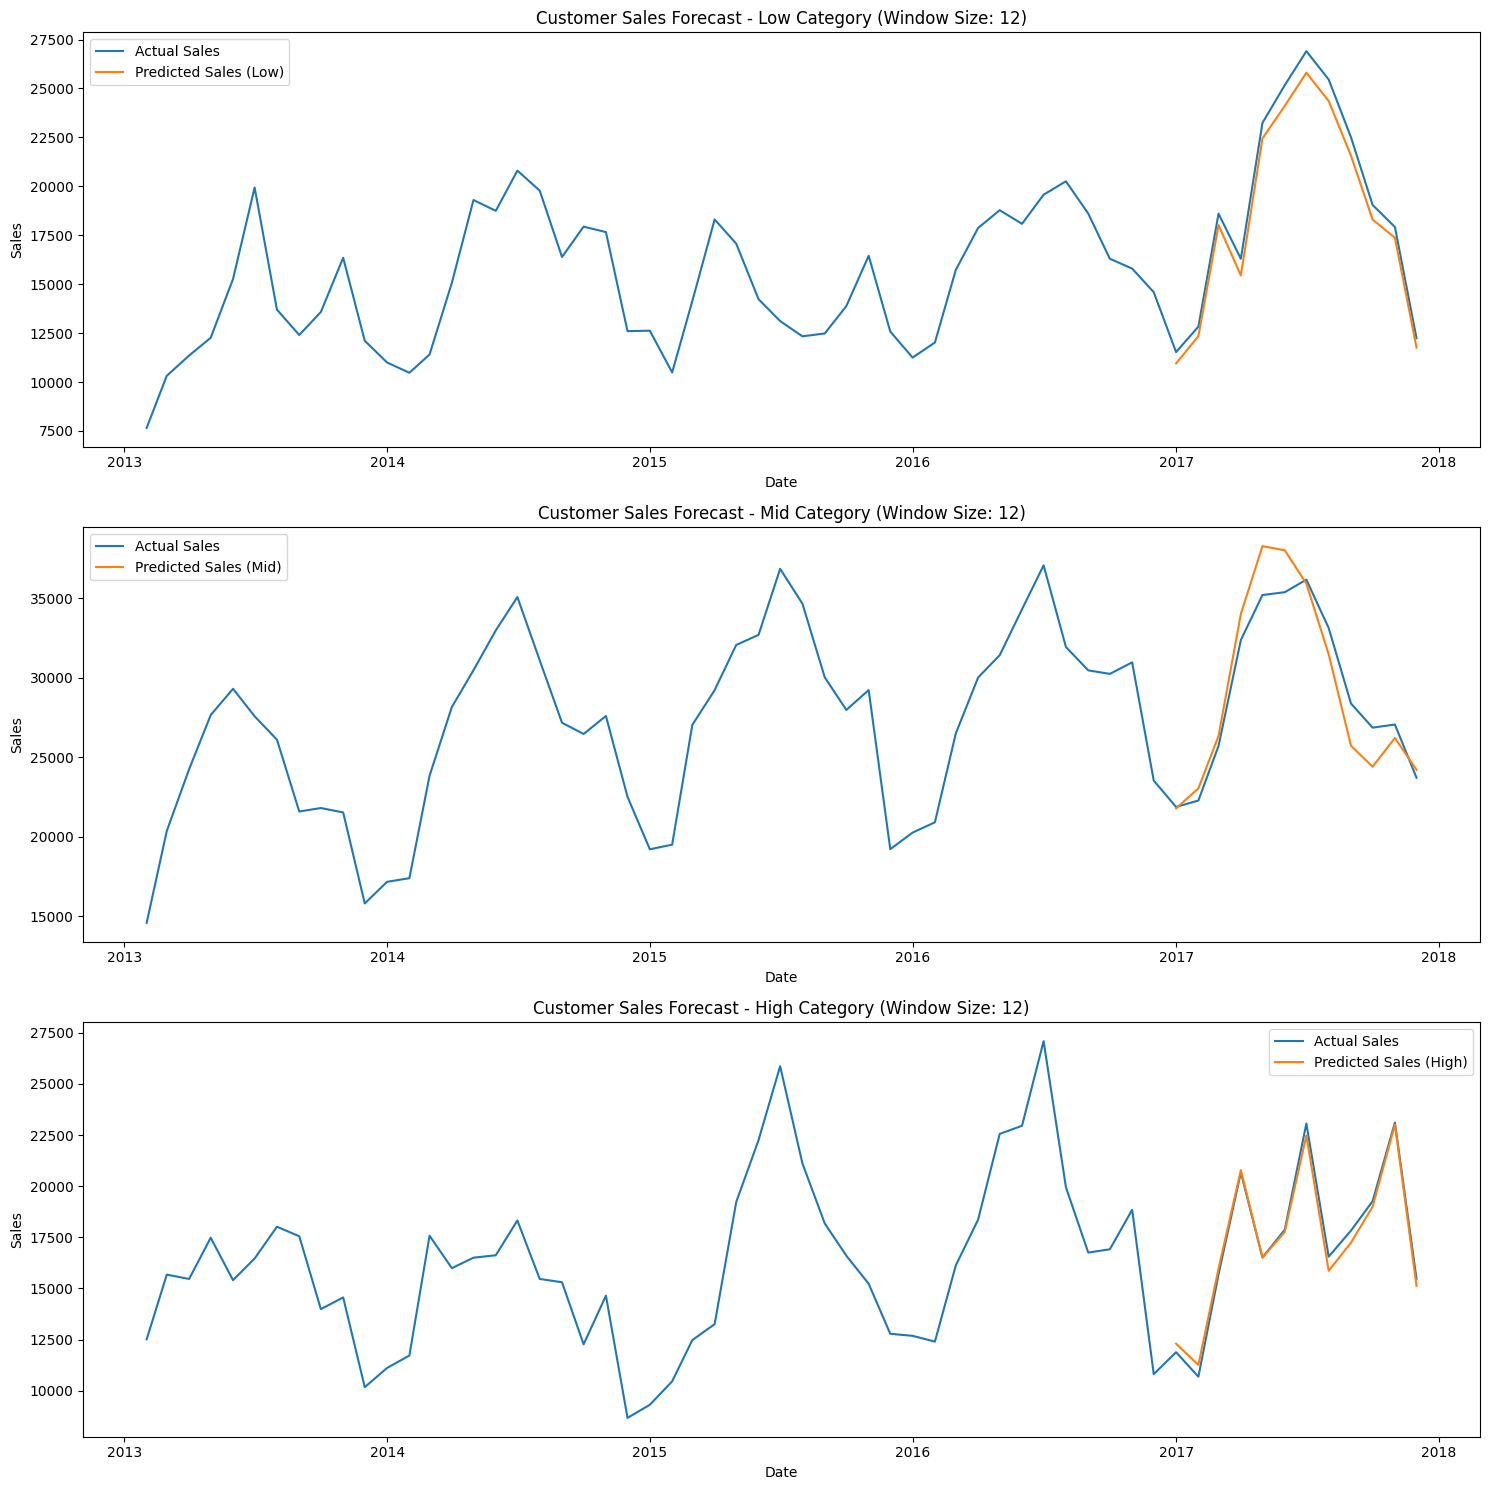

In [2]:
# Plot predictions by category
plt.figure(figsize=(15, 15))

# Low category plot
plt.subplot(3, 1, 1)
plt.plot(low_sales['date'], low_sales['sales'], label='Actual Sales')
plt.plot(low_predict_df['date'], low_predict_df['LSTM Prediction'], label='Predicted Sales (Low)')
plt.title("Customer Sales Forecast - Low Category (Window Size: 12)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

# Mid category plot
plt.subplot(3, 1, 2)
plt.plot(mid_sales['date'], mid_sales['sales'], label='Actual Sales')
plt.plot(mid_predict_df['date'], mid_predict_df['LSTM Prediction'], label='Predicted Sales (Mid)')
plt.title("Customer Sales Forecast - Mid Category (Window Size: 12)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

# High category plot
plt.subplot(3, 1, 3)
plt.plot(high_sales['date'], high_sales['sales'], label='Actual Sales')
plt.plot(high_predict_df['date'], high_predict_df['LSTM Prediction'], label='Predicted Sales (High)')
plt.title("Customer Sales Forecast - High Category (Window Size: 12)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load models
loaded_model_low = load_model('model/best_model_low.keras')
loaded_model_mid = load_model('model/best_model_mid.keras')
loaded_model_high = load_model('model/best_model_high.keras')

# Load new data from CSV file
new_data_url = 'https://raw.githubusercontent.com/C4AnN/Models/data/dataset/filtered_store_sales_2016_2017.csv'
new_data = pd.read_csv(new_data_url)

# Ensure 'date' column is in datetime format
new_data['date'] = pd.to_datetime(new_data['date'])

# Function to categorize price
def categorize_price(price):
    if price <= 8000000:
        return 'low'
    elif 8000000 < price <= 16000000:
        return 'mid'
    else:
        return 'high'

# Apply categorization
new_data['category'] = new_data['price'].apply(categorize_price)

# Function to make prediction for next month
def predict_next_month_sales(data, model, window_size=12):
    data['date'] = pd.to_datetime(data['date'])
    monthly_sales = data.resample('M', on='date').sum()
    
    # Extract sales data for the previous 11 months
    previous_11_months_sales = monthly_sales['sales'].iloc[-window_size-1:-1].values
    latest_month_sales = monthly_sales['sales'].iloc[-1]

    # Prepare input data for prediction
    input_data = np.array(previous_11_months_sales).reshape((1, window_size, 1))

    # Scale the input data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(input_data.reshape(-1, 1))
    input_data_scaled = scaler.transform(input_data.reshape(-1, 1)).reshape((1, window_size, 1))

    # Make prediction
    predicted_sales_scaled = model.predict(input_data_scaled)
    
    # Inverse transform to get actual sales value
    predicted_sales_actual = scaler.inverse_transform(predicted_sales_scaled.reshape(-1, 1))

    return predicted_sales_actual[0][0]

# Filter data for each category
new_data_low = new_data[new_data['category'] == 'low'].copy()
new_data_mid = new_data[new_data['category'] == 'mid'].copy()
new_data_high = new_data[new_data['category'] == 'high'].copy()

# Predict sales for next month for each category
predicted_sales_low = predict_next_month_sales(new_data_low, loaded_model_low)
predicted_sales_mid = predict_next_month_sales(new_data_mid, loaded_model_mid)
predicted_sales_high = predict_next_month_sales(new_data_high, loaded_model_high)

# Output predictions
print("Prediksi penjualan untuk bulan berikutnya (Low Category):", predicted_sales_low, "units")
print("Prediksi penjualan untuk bulan berikutnya (Mid Category):", predicted_sales_mid, "units")
print("Prediksi penjualan untuk bulan berikutnya (High Category):", predicted_sales_high, "units")


C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\3778253627.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\3778253627.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\3778253627.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
Prediksi penjualan untuk bulan berikutnya (Low Category): 19752.332 units
Prediksi penjualan untuk bulan berikutnya (Mid Category): 29196.088 units
Prediksi penjualan untuk bulan berikutnya (High Category): 15580.308 units


C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\546070947.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()
C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\546070947.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()
C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\546070947.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()


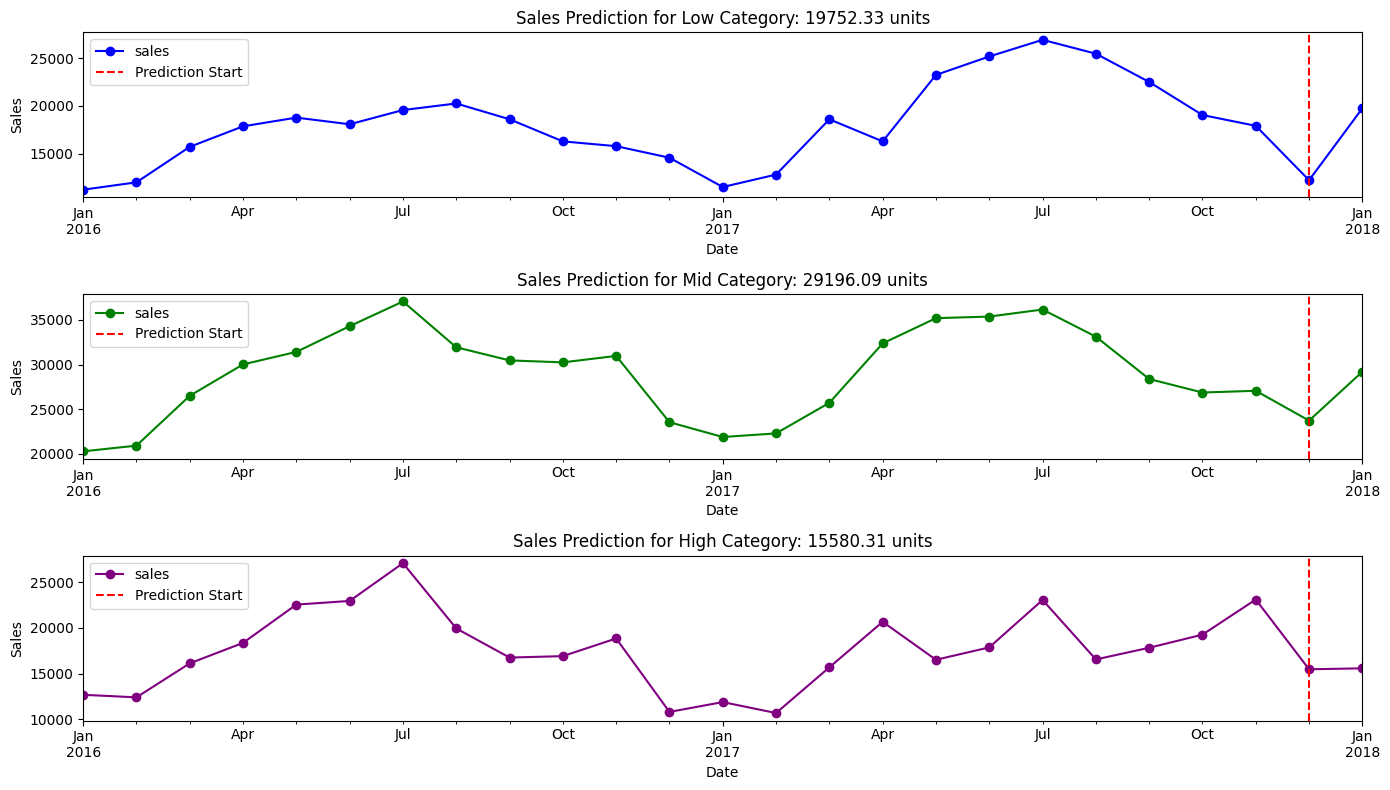

In [4]:
# Prepare data for plotting
def prepare_plot_data(data, predicted_sales, category_name):
    data['date'] = pd.to_datetime(data['date'])
    monthly_sales = data.resample('M', on='date').sum()
    last_date = monthly_sales.index[-1]
    next_month_date = last_date + pd.DateOffset(months=1)
    
    # Create a DataFrame for plotting
    plot_data = monthly_sales['sales'].copy()
    plot_data[next_month_date] = predicted_sales
    
    return plot_data

# Prepare data for each category
plot_data_low = prepare_plot_data(new_data_low, predicted_sales_low, 'low')
plot_data_mid = prepare_plot_data(new_data_mid, predicted_sales_mid, 'mid')
plot_data_high = prepare_plot_data(new_data_high, predicted_sales_high, 'high')

# Plot the data
plt.figure(figsize=(14, 8))

# Plot for low category
plt.subplot(3, 1, 1)
plot_data_low.plot(marker='o', color='blue', title=f'Sales Prediction for Low Category: {predicted_sales_low:.2f} units')
plt.axvline(plot_data_low.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

# Plot for mid category
plt.subplot(3, 1, 2)
plot_data_mid.plot(marker='o', color='green', title=f'Sales Prediction for Mid Category: {predicted_sales_mid:.2f} units')
plt.axvline(plot_data_mid.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

# Plot for high category
plt.subplot(3, 1, 3)
plot_data_high.plot(marker='o', color='purple', title=f'Sales Prediction for High Category: {predicted_sales_high:.2f} units')
plt.axvline(plot_data_high.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

plt.tight_layout()
plt.show()


In [5]:
# Prediksi dengan data 5 Tahun

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load models
loaded_model_low = load_model('model/best_model_low.keras')
loaded_model_mid = load_model('model/best_model_mid.keras')
loaded_model_high = load_model('model/best_model_high.keras')

# Load new data from CSV file
new_data_url = 'https://raw.githubusercontent.com/C4AnN/Models/data/dataset_processing%20(Model%20LR%202)/file_gabungan2.csv'
new_data = pd.read_csv(new_data_url)

# Ensure 'date' column is in datetime format
new_data['date'] = pd.to_datetime(new_data['date'])

# Function to categorize price
def categorize_price(price):
    if price <= 8000000:
        return 'low'
    elif 8000000 < price <= 16000000:
        return 'mid'
    else:
        return 'high'

# Apply categorization
new_data['category'] = new_data['price'].apply(categorize_price)

# Function to make prediction for next month
def predict_next_month_sales(data, model, window_size=12):
    data['date'] = pd.to_datetime(data['date'])
    monthly_sales = data.resample('M', on='date').sum()
    
    # Extract sales data for the previous 11 months
    previous_11_months_sales = monthly_sales['sales'].iloc[-window_size-1:-1].values
    latest_month_sales = monthly_sales['sales'].iloc[-1]

    # Prepare input data for prediction
    input_data = np.array(previous_11_months_sales).reshape((1, window_size, 1))

    # Scale the input data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(input_data.reshape(-1, 1))
    input_data_scaled = scaler.transform(input_data.reshape(-1, 1)).reshape((1, window_size, 1))

    # Make prediction
    predicted_sales_scaled = model.predict(input_data_scaled)
    
    # Inverse transform to get actual sales value
    predicted_sales_actual = scaler.inverse_transform(predicted_sales_scaled.reshape(-1, 1))

    return predicted_sales_actual[0][0]

# Filter data for each category
new_data_low = new_data[new_data['category'] == 'low'].copy()
new_data_mid = new_data[new_data['category'] == 'mid'].copy()
new_data_high = new_data[new_data['category'] == 'high'].copy()

# Predict sales for next month for each category
predicted_sales_low = predict_next_month_sales(new_data_low, loaded_model_low)
predicted_sales_mid = predict_next_month_sales(new_data_mid, loaded_model_mid)
predicted_sales_high = predict_next_month_sales(new_data_high, loaded_model_high)

# Output predictions
print("Prediksi penjualan untuk bulan berikutnya (Low Category):", predicted_sales_low, "units")
print("Prediksi penjualan untuk bulan berikutnya (Mid Category):", predicted_sales_mid, "units")
print("Prediksi penjualan untuk bulan berikutnya (High Category):", predicted_sales_high, "units")


C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\995767942.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\995767942.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\995767942.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
Prediksi penjualan untuk bulan berikutnya (Low Category): 19752.332 units
Prediksi penjualan untuk bulan berikutnya (Mid Category): 29196.088 units
Prediksi penjualan untuk bulan berikutnya (High Category): 15580.308 units


C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\546070947.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()
C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\546070947.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()
C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\546070947.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()


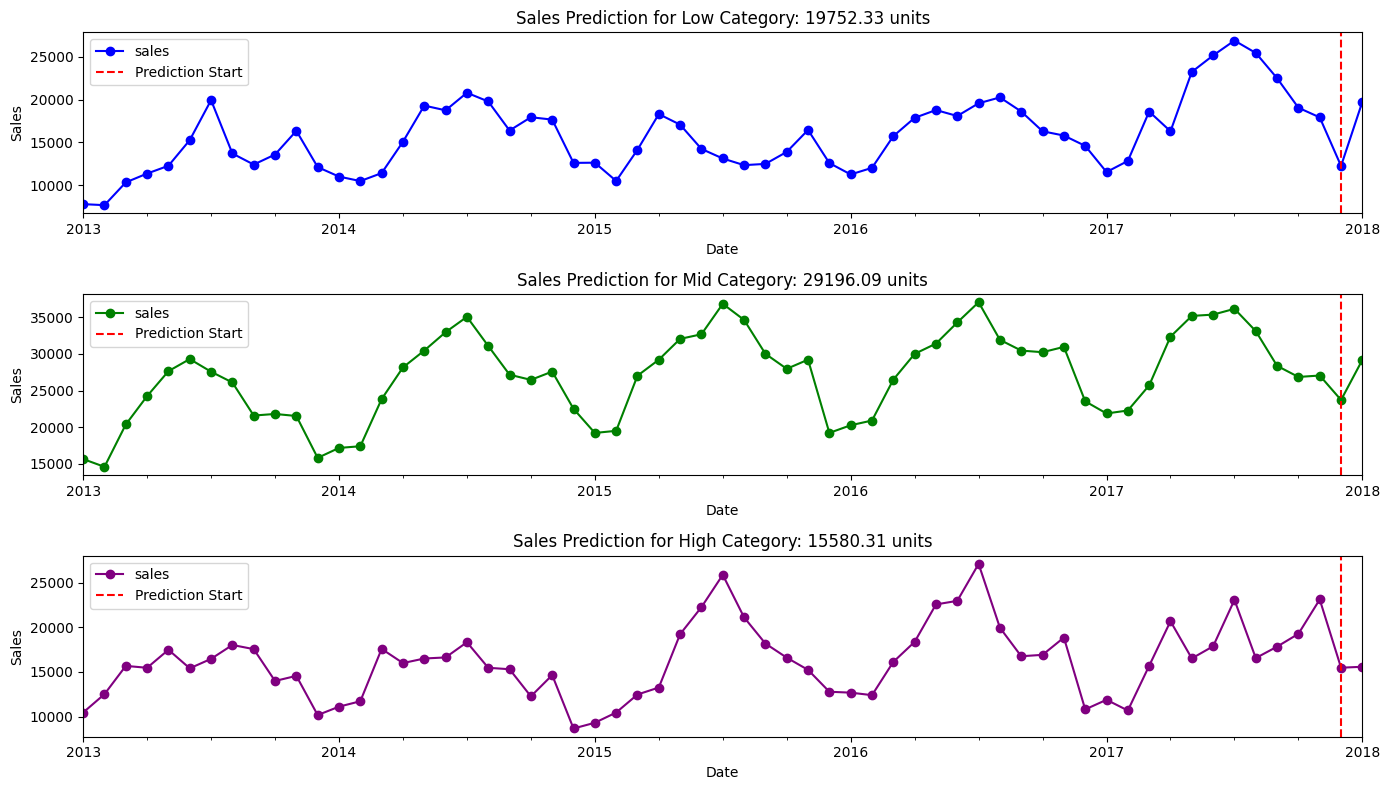

In [7]:
# Prepare data for plotting
def prepare_plot_data(data, predicted_sales, category_name):
    data['date'] = pd.to_datetime(data['date'])
    monthly_sales = data.resample('M', on='date').sum()
    last_date = monthly_sales.index[-1]
    next_month_date = last_date + pd.DateOffset(months=1)
    
    # Create a DataFrame for plotting
    plot_data = monthly_sales['sales'].copy()
    plot_data[next_month_date] = predicted_sales
    
    return plot_data

# Prepare data for each category
plot_data_low = prepare_plot_data(new_data_low, predicted_sales_low, 'low')
plot_data_mid = prepare_plot_data(new_data_mid, predicted_sales_mid, 'mid')
plot_data_high = prepare_plot_data(new_data_high, predicted_sales_high, 'high')

# Plot the data
plt.figure(figsize=(14, 8))

# Plot for low category
plt.subplot(3, 1, 1)
plot_data_low.plot(marker='o', color='blue', title=f'Sales Prediction for Low Category: {predicted_sales_low:.2f} units')
plt.axvline(plot_data_low.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

# Plot for mid category
plt.subplot(3, 1, 2)
plot_data_mid.plot(marker='o', color='green', title=f'Sales Prediction for Mid Category: {predicted_sales_mid:.2f} units')
plt.axvline(plot_data_mid.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

# Plot for high category
plt.subplot(3, 1, 3)
plot_data_high.plot(marker='o', color='purple', title=f'Sales Prediction for High Category: {predicted_sales_high:.2f} units')
plt.axvline(plot_data_high.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

plt.tight_layout()
plt.show()


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Load models
loaded_model_low = load_model('model/best_model_low.keras')
loaded_model_mid = load_model('model/best_model_mid.keras')
loaded_model_high = load_model('model/best_model_high.keras')

# Load new data from CSV file
new_data_url = 'dataset/filtered_store_sales_2016.csv'
new_data = pd.read_csv(new_data_url)

# Ensure 'date' column is in datetime format
new_data['date'] = pd.to_datetime(new_data['date'])

# Function to categorize price
def categorize_price(price):
    if price <= 8000000:
        return 'low'
    elif 8000000 < price <= 16000000:
        return 'mid'
    else:
        return 'high'

# Apply categorization
new_data['category'] = new_data['price'].apply(categorize_price)

# Function to make prediction for next month
def predict_next_month_sales(data, model, window_size=12):
    data['date'] = pd.to_datetime(data['date'])
    monthly_sales = data.set_index('date').resample('M').sum()

    # If there are more than 12 months of data, use the last 12 months
    if len(monthly_sales) > window_size:
        monthly_sales = monthly_sales.iloc[-window_size:]

    # Extract sales data for the previous window_size months
    previous_sales = monthly_sales['sales'].values

    # If there are less than 12 months of data, pad the data with zeros
    if len(previous_sales) < window_size:
        previous_sales = np.pad(previous_sales, (window_size - len(previous_sales), 0), 'constant')

    # Prepare input data for prediction
    input_data = np.array(previous_sales).reshape((1, window_size, 1))

    # Scale the input data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    input_data_scaled = scaler.fit_transform(input_data.reshape(-1, 1)).reshape((1, window_size, 1))

    # Make prediction
    predicted_sales_scaled = model.predict(input_data_scaled)
    
    # Inverse transform to get actual sales value
    predicted_sales_actual = scaler.inverse_transform(predicted_sales_scaled.reshape(-1, 1))

    return predicted_sales_actual[0][0]

# Filter data for each category
new_data_low = new_data[new_data['category'] == 'low'].copy()
new_data_mid = new_data[new_data['category'] == 'mid'].copy()
new_data_high = new_data[new_data['category'] == 'high'].copy()

# Predict sales for next month (13th month) for each category
predicted_sales_low = predict_next_month_sales(new_data_low, loaded_model_low)
print("Prediksi penjualan untuk bulan ke-13 (Low Category):", predicted_sales_low, "units")

predicted_sales_mid = predict_next_month_sales(new_data_mid, loaded_model_mid)
print("Prediksi penjualan untuk bulan ke-13 (Mid Category):", predicted_sales_mid, "units")

predicted_sales_high = predict_next_month_sales(new_data_high, loaded_model_high)
print("Prediksi penjualan untuk bulan ke-13 (High Category):", predicted_sales_high, "units")


C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\41537163.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.set_index('date').resample('M').sum()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
Prediksi penjualan untuk bulan ke-13 (Low Category): 142813.3 units


C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\41537163.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.set_index('date').resample('M').sum()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Prediksi penjualan untuk bulan ke-13 (Mid Category): 93540.67 units


C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\41537163.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.set_index('date').resample('M').sum()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Prediksi penjualan untuk bulan ke-13 (High Category): 116997.97 units


C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\4156526427.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()
C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\4156526427.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()
C:\Users\MyPC\AppData\Local\Temp\ipykernel_13604\4156526427.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.resample('M', on='date').sum()


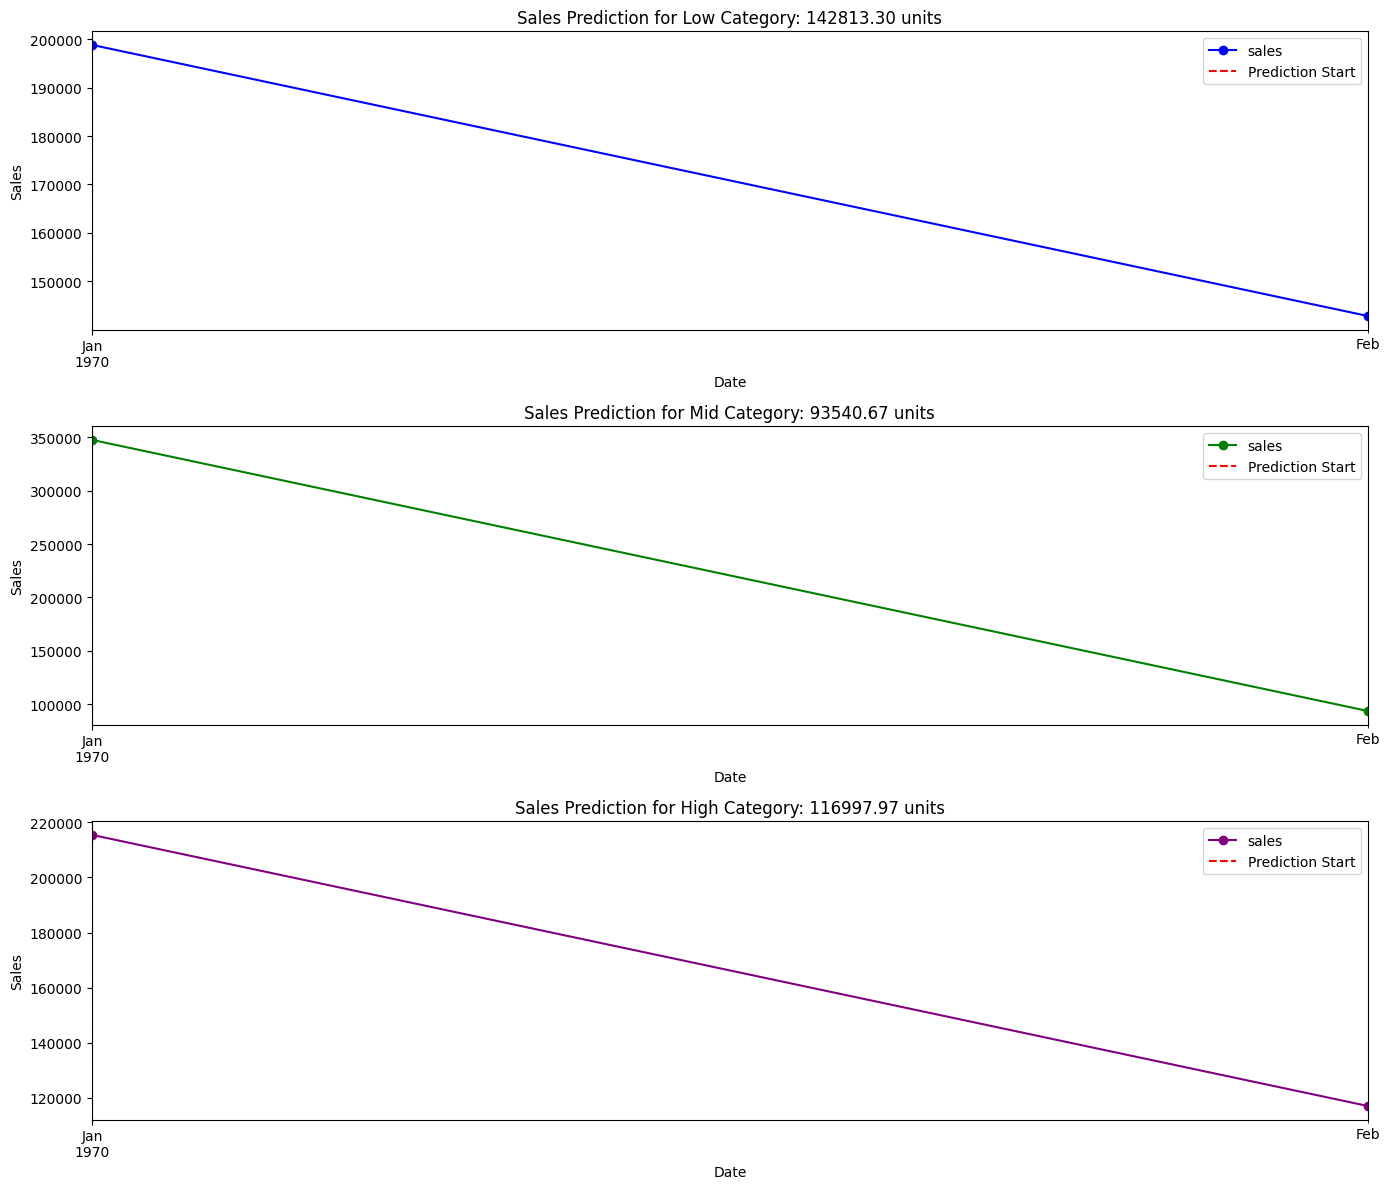

In [9]:
# Prepare data for plotting
def prepare_plot_data(data, predicted_sales, category_name):
    data['date'] = pd.to_datetime(data['date'])
    monthly_sales = data.resample('M', on='date').sum()
    last_date = monthly_sales.index[-1]
    next_month_date = last_date + pd.DateOffset(months=1)
    
    # Create a DataFrame for plotting
    plot_data = monthly_sales['sales'].copy()
    if predicted_sales is not None:
        plot_data[next_month_date] = predicted_sales
    
    return plot_data

# Prepare data for each category
plot_data_low = prepare_plot_data(new_data_low, predicted_sales_low, 'low')
plot_data_mid = prepare_plot_data(new_data_mid, predicted_sales_mid, 'mid')
plot_data_high = prepare_plot_data(new_data_high, predicted_sales_high, 'high')

# Plot the data
plt.figure(figsize=(14, 12))

# Plot for low category
plt.subplot(3, 1, 1)
plot_data_low.plot(marker='o', color='blue', title=f'Sales Prediction for Low Category: {predicted_sales_low:.2f} units' if predicted_sales_low is not None else "Not enough data for Low Category")
if predicted_sales_low is not None:
    plt.axvline(plot_data_low.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

# Plot for mid category
plt.subplot(3, 1, 2)
plot_data_mid.plot(marker='o', color='green', title=f'Sales Prediction for Mid Category: {predicted_sales_mid:.2f} units' if predicted_sales_mid is not None else "Not enough data for Mid Category")
if predicted_sales_mid is not None:
    plt.axvline(plot_data_mid.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

# Plot for high category
plt.subplot(3, 1, 3)
plot_data_high.plot(marker='o', color='purple', title=f'Sales Prediction for High Category: {predicted_sales_high:.2f} units' if predicted_sales_high is not None else "Not enough data for High Category")
if predicted_sales_high is not None:
    plt.axvline(plot_data_high.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

plt.tight_layout()
plt.show()